In [31]:
import openmc 
import pandas as pd
import openmc.deplete as od
import math
import matplotlib.pyplot as plt
openmc.config['cross_sections'] = "/home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/cross_sections.xml"

## VOYGR model
The VOYGR modeled is simplified by using a PWR assembly model, specifically the [example model 
in OpenMC](https://docs.openmc.org/en/latest/pythonapi/generated/openmc.examples.pwr_assembly.html#openmc.examples.pwr_assembly).
The Fuel material is modified to be 4.09% weight fraction U-235, in a UO2 form. This modification 
matches the input fuel for the VOYGR used in the transition scenarios.

In [ ]:
pwr_model = openmc.examples.pwr_assembly()

pwr_model.materials[0].nuclides.clear()
pwr_model.materials[0].add_nuclide("U235", 0.0404, 'ao')
pwr_model.materials[0].add_nuclide("U238", 0.9596, 'ao')
pwr_model.materials[0].add_nuclide("O16", 2, 'ao')
fuel = pwr_model.materials[0]

openmc.config['cross_sections'] = "/home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/cross_sections.xml"

In [ ]:
voygr_cross_sections = od.MicroXS.from_model(pwr_model, 
                                       domain = fuel, 
                                       chain_file="./voygr/chain_casl_pwr.xml")

 Reading In113 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/In113.h5
 Reading In115 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/In115.h5
 Reading Sb121 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Sb121.h5
 Reading Sb123 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Sb123.h5
 Reading Sb125 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Sb125.h5
 Reading Te127_m1 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Te127_m1.h5
 Reading Te129_m1 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Te129_m1.h5
 Reading Te132 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Te132.h5
 Reading I127 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/I127.h5
 Reading I128 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/I128.h5
 Reading I129 from
 /home/abachmann@anl.go

 Reading Gd154 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd154.h5
 Reading Gd155 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd155.h5
 Reading Gd156 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd156.h5
 Reading Gd157 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd157.h5
 Reading Gd158 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd158.h5
 Reading Gd159 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd159.h5
 Reading Gd160 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd160.h5
 Reading Tb159 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb159.h5
 Reading Tb160 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb160.h5
 Reading Tb161 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb161.h5
 Reading Dy160 from
 /home/abachmann@anl.gov/openm

In [ ]:
voygr_cross_sections.to_csv("voygr/micro_xs.csv")

In [ ]:
voygr_cross_sections

### Calculate Pu equivalence for MOX recipe

In [ ]:
nu_235 = 2.4355
nu_238 = 2.819
nu_239 = 2.836

In [ ]:
p_235 = nu_235*voygr_cross_sections.loc['U235']['fission'] - voygr_cross_sections.loc['U235']['(n,gamma)']
p_238 = nu_238*voygr_cross_sections.loc['U238']['fission'] - voygr_cross_sections.loc['U238']['(n,gamma)']
p_239 = nu_239*voygr_cross_sections.loc['Pu239']['fission'] - voygr_cross_sections.loc['Pu239']['(n,gamma)']

In [ ]:
equivalence = (p_235-p_238)/(p_239-p_238)

In [ ]:
Pu_enrich = 4.09/equivalence
Pu_enrich # weight fraction of the actinides

## Xe-100 model 

This data is based on the Serpent model of the Sanagmon200. Serpent generated the cross 
section data, which then was converted to the correct form for OpenMC

In [ ]:
file = "./htgr-mr-full-core.inp_mdx0.m"
serpent_data = pd.read_csv(file, skiprows=1, skipfooter=2,delimiter=' ', usecols=[0,3,10], header=None)

In [ ]:
openmc_data = pd.DataFrame(columns=['nuclide','(n,gamma)','(n,2n)','(n,p)','(n,a)','(n,3n)','(n,4n)','fission'])

In [ ]:
for ii in range(0, 3318,6):
    zai = int(serpent_data.iloc[ii][0])
    Z= math.floor(zai/10000)
    A=math.floor((zai-Z*10000)/10)
    m = zai -(Z*10000 +A*10)
    nucname = openmc.data.gnds_name(Z,A,m)
    dictionary = {'nuclide':nucname, '(n,gamma)':serpent_data.iloc[ii][10],
                  '(n,2n)':serpent_data.iloc[ii+1][10],'(n,p)':serpent_data.iloc[ii+2][10],
                  '(n,a)':serpent_data.iloc[ii+3][10],'(n,3n)':serpent_data.iloc[ii+4][10],
                  '(n,4n)':0.0, 'fission':serpent_data.iloc[ii+5][10]}
    openmc_data.loc[len(openmc_data)] = dictionary
# append on last nuclide
openmc_data.loc[len(openmc_data)] = {'nuclide':'Es255', '(n,gamma)':0,
                  '(n,2n)':0,'(n,p)':0,
                  '(n,a)':serpent_data.iloc[ii+3][10],'(n,3n)':0,
                  '(n,4n)':0.0, 'fission':0}
openmc_data = openmc_data.set_index('nuclide')

In [ ]:
openmc_data.to_csv("./xe-100/micro_xs.csv")

In [ ]:
xe100_cross_sections = od.MicroXS.from_csv("./xe-100/micro_xs.csv")

### Calculate Pu equivalence for MOX

In [ ]:
nu_235 = 2.4355
nu_238 = 2.819
nu_239 = 2.836

In [ ]:
p_235 = nu_235*xe100_cross_sections.loc['U235']['fission'] - xe100_cross_sections.loc['U235']['(n,gamma)']
p_238 = nu_238*xe100_cross_sections.loc['U238']['fission'] - xe100_cross_sections.loc['U238']['(n,gamma)']
p_239 = nu_239*xe100_cross_sections.loc['Pu239']['fission'] - xe100_cross_sections.loc['Pu239']['(n,gamma)']

In [ ]:
equivalence = (p_235-p_238)/(p_239-p_238)

In [ ]:
Pu_enrich = 15.5/equivalence
Pu_enrich # weight fraction of the actinides

# Sodium Fast Reactor
SFR Model for use in transition scenarios with a closed fuel cycle. Starting the model from the
[sample SFR model from OpenMC](https://nbviewer.org/github/mit-crpg/openmc-reactor-examples/blob/main/SFR.ipynb),
and adjusted with information from the PRISM reactor as available. 

Sources: 
* Brian S. Triplett, Eric P. Loewen & Brett J. Dooies (2012) PRISM: A Competitive Small Modular Sodium-Cooled Reactor, Nuclear Technology, 178:2, 186-200, DOI: 10.13182/NT178-186

In [2]:
sfr_model = openmc.Model()

In [3]:
# Materials definitions

u235 = openmc.Material(name='U235')
u235.add_nuclide('U235', 1.0)
u235.set_density('g/cm3', 15.05)

u238 = openmc.Material(name='U238')
u238.add_nuclide('U238', 1.0)
u238.set_density('g/cm3', 15.05)

pu239 = openmc.Material(name='U235')
pu239.add_nuclide('Pu239', 1.0)
pu239.set_density('g/cm3', 15.05)

pu240 = openmc.Material(name='Pu240')
pu240.add_nuclide('Pu240', 1.0)
pu240.set_density('g/cm3', 15.05)

pu241 = openmc.Material(name='Pu241')
pu241.add_nuclide('Pu241', 1.0)
pu241.set_density('g/cm3', 15.05)

pu242 = openmc.Material(name='Pu242')
pu242.add_nuclide('Pu242', 1.0)
pu242.set_density('g/cm3', 15.05)

am241 = openmc.Material(name='Am241')
am241.add_nuclide('Am241', 1.0)
am241.set_density('g/cm3', 15.05)

zr90 = openmc.Material(name='Zr90')
zr90.add_nuclide('Zr90', 1.0)
zr90.set_density('g/cm3', 15.05)

sodium = openmc.Material(name='Na')
sodium.add_nuclide('Na23', 1.0)
sodium.set_density('g/cm3', 0.96)

fe56 = openmc.Material(name='Fe56')
fe56.set_density('g/cm3', 7.73)
fe56.add_nuclide('Fe56', 1.0)

cr52 = openmc.Material(name='Cr52')
cr52.set_density('g/cm3', 7.73)
cr52.add_nuclide('Cr52', 1.0)
                  
mo = openmc.Material(name='Mo')
mo.set_density('g/cm3', 7.73)
mo.add_element('Mo', 1.0)

In [4]:
# Material mixtures
inner = openmc.Material.mix_materials(
    [u235, u238, pu239, pu240, pu241, pu242, am241, zr90],
    [0.0051, 0.7059, 0.1010, 0.0495, 0.0120, 0.0038, 0.0227, 0.10],
    'wo')
outer = openmc.Material.mix_materials(
    [u235, u238, pu239, pu240, pu241, pu242, am241, zr90],
    [0.00478, 0.66822, 0.12064, 0.05993, 0.01436, 0.00463, 0.02744, 0.10],
    'wo')
clad = openmc.Material.mix_materials(
    [fe56, cr52, mo], [0.87, 0.12, 0.01], 'wo')

#inner.volume = 15.5496
#outer.volume = 15.5496
#clad.volume = 7.69152

In [5]:
# Instantiate a Materials collection and export to xml
materials_file = openmc.Materials([inner, outer, sodium, clad])
materials_file.export_to_xml()

In [6]:
# Geometry definitions

fuel_or = openmc.ZCylinder(surface_id=1, r=0.27385) 
clad_ir = openmc.ZCylinder(surface_id=2, r=0.30385) 
clad_or = openmc.ZCylinder(surface_id=3, r=0.35975) 

top = openmc.ZPlane(surface_id=4, z0=+33, boundary_type='vacuum')
bottom = openmc.ZPlane(surface_id=5, z0=-33, boundary_type='vacuum') 

fuel_region = -fuel_or & -top & +bottom
gap_region  = +fuel_or & -clad_ir  & -top & +bottom
clad_region = +clad_ir & -clad_or  & -top & +bottom
moderator_region = +clad_or & -top & +bottom
 
gap_cell = openmc.Cell(cell_id=1, fill=inner, region=gap_region, name='gap cell')
clad_cell = openmc.Cell(cell_id=2, fill=clad, region=clad_region, name='clad cell')
sodium_cell = openmc.Cell(cell_id=3,fill=sodium, region=moderator_region, name='sodium cell')

In [7]:
inner_fuel_cell = openmc.Cell(cell_id=4, fill=inner, region=fuel_region, name='inner fuel cell')
inner_u = openmc.Universe(universe_id=1, cells=(inner_fuel_cell, gap_cell, clad_cell, sodium_cell), name='inner u')

In [37]:
#outer_fuel_cell = openmc.Cell(cell_id=5, fill=outer, region=fuel_region, name='outer fuel cell')
#outer_u = openmc.Universe(universe_id=2, cells=(outer_fuel_cell, gap_cell, clad_cell, sodium_cell), name='outer u')
outer_fuel_cell = openmc.Cell(cell_id=5, fill=outer, region=fuel_region)

# reserve the next 10 cell IDs to avoid an ID 
openmc.reserve_ids(range(6, 16), openmc.Cell)
cloned_cells = [c.clone(clone_materials=False, clone_regions=False) for c in [gap_cell, clad_cell, sodium_cell]]
outer_u = openmc.Universe(universe_id=2, cells=[outer_fuel_cell]+cloned_cells)

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=5.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=2.
  warn(msg, IDWarning)


In [38]:
# Creating filling for emtpy space in the core
sodium_mod_cell = openmc.Cell(cell_id=6, fill=sodium, name='sodium mod cell')
sodium_mod_u = openmc.Universe(universe_id=3, cells=(sodium_mod_cell,), name='sodium mod u')
#sodium_in_cell = openmc.Cell(cell_id=6, fill=sodium, name='sodium in cell')
#sodium_in_u = openmc.Universe(universe_id=3, cells=(sodium_in_cell,), name='sodium in u')
#sodium_out_cell = openmc.Cell(cell_id=20, fill=sodium, name='sodium out cell')
#sodium_out_u = openmc.Universe(universe_id=15, cells=(sodium_out_cell,), name='sodium out u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=6.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=3.
  warn(msg, IDWarning)


In [39]:
# Define a lattice for inner assemblies
in_lat = openmc.HexLattice(lattice_id=100, name='inner assembly')
in_lat.center = (0., 0.)
in_lat.pitch = [0.8495] #21.08/17 # 16.142
in_lat.orientation = 'x'
in_lat.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
inten = [inner_u]*54
inone = [inner_u]*48 #36
intwo = [inner_u]*42 #28
inthree = [inner_u]*36 #21
infour = [inner_u]*30 #15
infive = [inner_u]*24 #10
insix = [inner_u]*18 #6
inseven = [inner_u]*12 #3
ineight = [inner_u]*6 #1
innine = [inner_u]*1
in_lat.universes = [inten, inone,intwo,inthree,infour,infive,insix,inseven,ineight,innine]

# Create the prism that will contain the lattice
outer_in_surface = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly = openmc.Cell(cell_id=7, fill=in_lat, region=outer_in_surface & -top & +bottom, name='main in assembly')

# Fill a cell with a material that will surround the lattice
out_in_assembly  = openmc.Cell(cell_id=8, fill=sodium, region=~outer_in_surface & -top & +bottom, name='out in assembly')

# Create a universe that contains both 
main_in_u = openmc.Universe(universe_id=4, cells=[main_in_assembly, out_in_assembly], name='main in u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=7.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=8.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=4.
  warn(msg, IDWarning)


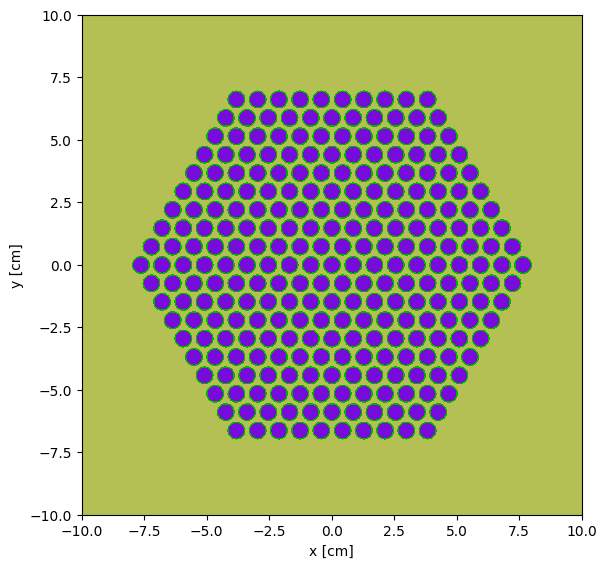

In [41]:
main_in_u.plot(origin = (0,0,0), pixels=(500, 500), width = (20.,20.), color_by = 'material')

In [47]:
# Define a lattice for outer assemblies
out_lat = openmc.HexLattice(lattice_id=200, name='outer assembly')
out_lat.center = (0., 0.)
out_lat.pitch = (0.8495,)
out_lat.orientation = 'x'
out_lat.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
outten = [outer_u]*54
outone = [outer_u]*48
outtwo = [outer_u]*42
outthree = [outer_u]*36
outfour = [outer_u]*30
outfive = [outer_u]*24
outsix = [outer_u]*18
outseven = [outer_u]*12
outeight = [outer_u]*6
outnine = [outer_u]*1
out_lat.universes = [outten, outone,outtwo,outthree,outfour,outfive,outsix,outseven,outeight,outnine]

# Create the prism that will contain the lattice
outer_out_surface = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly = openmc.Cell(cell_id=9, fill=out_lat, region=outer_out_surface & -top & +bottom, name='main out assembly')

# Fill a cell with a material that will surround the lattice
out_out_assembly  = openmc.Cell(cell_id=10, fill=sodium,  region=~outer_out_surface & -top & +bottom, name='out out assembly')

# Create a universe that contains both 
main_out_u = openmc.Universe(universe_id=5, cells=[main_out_assembly, out_out_assembly], name='main out u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Lattice instance already exists with id=200.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=9.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=10.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=5.
  warn(msg, IDWarning)


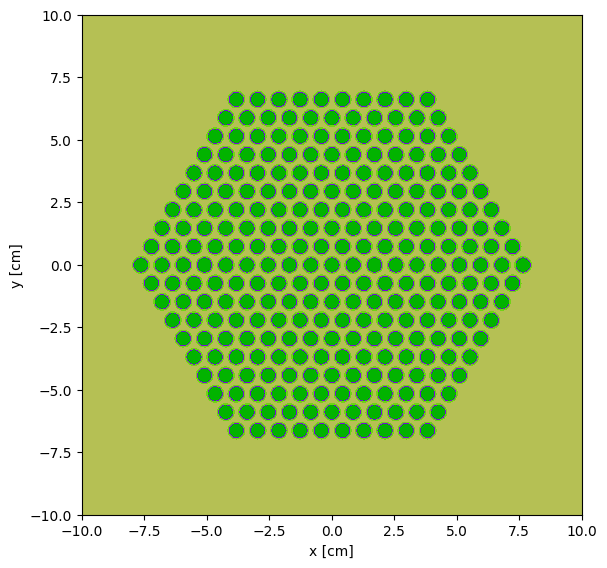

In [48]:
main_out_u.plot(origin = (0,0,0), pixels=(500, 500), width = (20.,20.), color_by = 'material')

In [49]:
# Create a hexagonal water cell -- can use for non-fuel assemblies

reflector_assembly = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')
ref_cell = openmc.Cell(cell_id=11, fill=sodium, region=reflector_assembly & -top & +bottom, name='ref cell')
out_ref_cell  = openmc.Cell(cell_id=12, fill=sodium, region=~reflector_assembly & -top & +bottom, name='out ref cell')
ref_u = openmc.Universe(universe_id=6, cells=[ref_cell, out_ref_cell], name='ref u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=11.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=12.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=6.
  warn(msg, IDWarning)


In [50]:
core_lat = openmc.HexLattice(lattice_id=300, name='core')
core_lat.center = (0., 0.)
core_lat.pitch = (16.142,)
core_lat.outer = sodium_mod_u

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Lattice instance already exists with id=300.
  warn(msg, IDWarning)


In [51]:
# Create rings of fuel universes that will fill the lattice
ring_one = [ref_u]*66
ring_two = [ref_u]*60
ring_three = [ref_u]*54
ring_four = ([ref_u] + [main_out_u]*7 + [ref_u] + [main_out_u]*7 + 
             [ref_u] + [main_out_u]*7 + [ref_u] + [main_out_u]*7 +
             [ref_u] + [main_out_u]*7 + [ref_u] + [main_out_u]*7)
ring_five = ([ref_u] + [main_out_u]*6 + [ref_u] + [main_out_u]*6 + 
             [ref_u] + [main_out_u]*6 + [ref_u] + [main_out_u]*6 +
             [ref_u] + [main_out_u]*6 + [ref_u] + [main_out_u]*6)
ring_six = ([main_out_u]*3 + [ref_u] + [main_out_u]*5 + [ref_u] + [main_out_u]*5 + 
            [ref_u] + [main_out_u]*5 + [ref_u] + [main_out_u]*5 + [ref_u] + 
            [main_out_u]*5 + [ref_u] + [main_out_u]*2)

ring_seven = [main_in_u]*30
ring_eight = [main_in_u]*24
ring_nine = ([ref_u] + [main_in_u]*2 + [ref_u] + [main_in_u]*2 + [ref_u] + [main_in_u]*2 + 
             [ref_u] + [main_in_u]*2 + [ref_u] + [main_in_u]*2 + [ref_u] + [main_in_u]*2)
ring_ten = [main_in_u]*12
ring_eleven = [main_in_u]*6
ring_twelve = [ref_u]*1
core_lat.universes = [ring_one, ring_two, ring_three, ring_four, ring_five,ring_six, ring_seven, ring_eight, ring_nine, ring_ten, ring_eleven, ring_twelve]

In [52]:
# Create the prism that will contain the lattice
outer_core_surface = openmc.model.hexagonal_prism(edge_length=214.351, boundary_type='vacuum')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
core = openmc.Cell(cell_id=13, fill=core_lat, region=outer_core_surface & -top & +bottom, name='core cell')

# Fill a cell with a material that will surround the lattice
out_core = openmc.Cell(cell_id=14, fill=outer, region=~outer_core_surface & -top & +bottom, name='out core')

# Create a universe that contains both 
main_u = openmc.Universe(universe_id=7,cells=[core, out_core], name='main u')


/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=13.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=14.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=7.
  warn(msg, IDWarning)


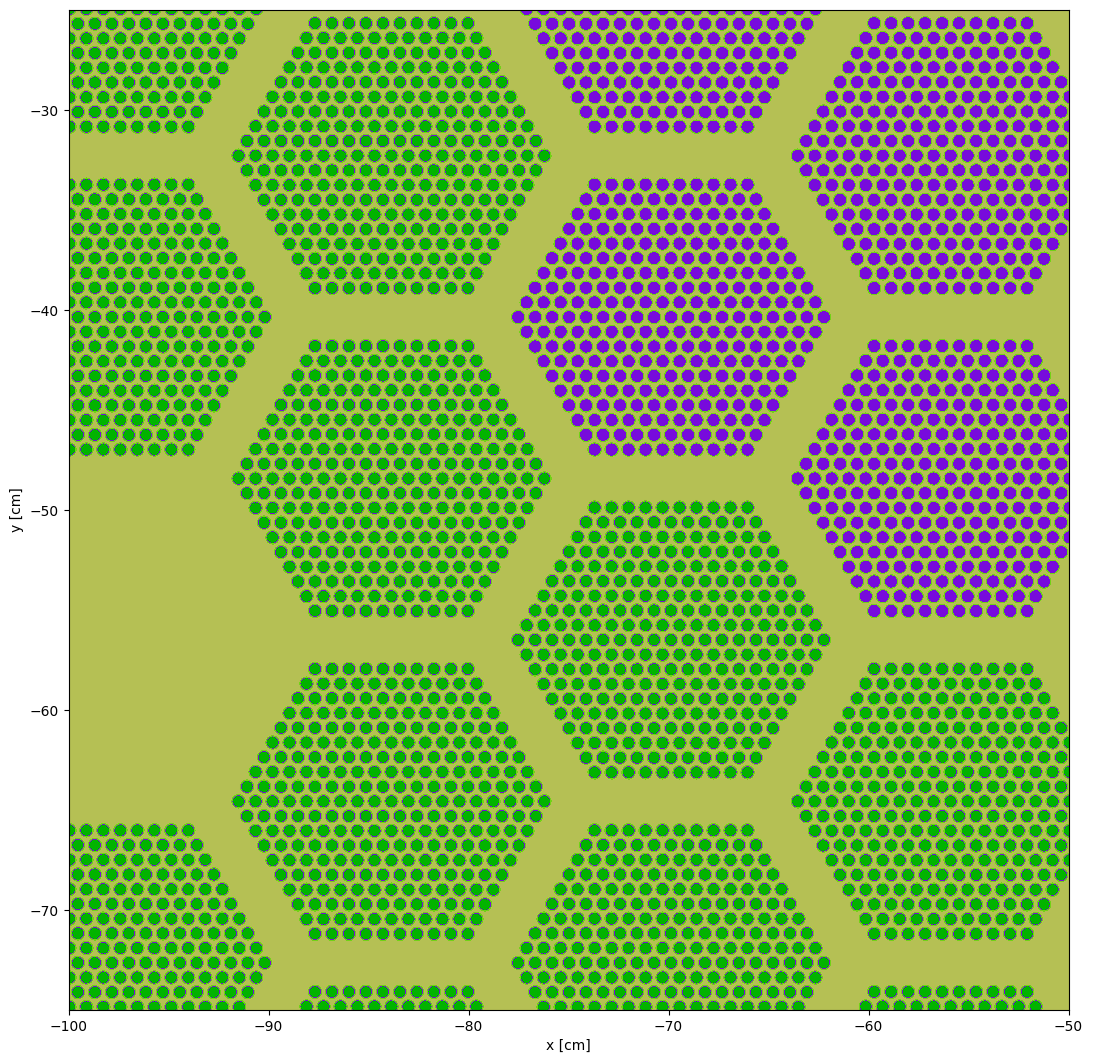

In [53]:
fig = main_u.plot(origin =(-75,-50,0), pixels=(1000, 1000), width = (50.,50.), color_by = 'material')
plt.savefig("sfr_core_lattice.png")

In [54]:
geometry = openmc.Geometry(main_u)
geometry.export_to_xml()

In [55]:
# OpenMC simulation parameters

lower_left = [-300, -300, -50]
upper_right = [300, 300, 50]
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)
src = openmc.Source(space=uniform_dist)

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/source.py:388: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [59]:
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1500

settings.export_to_xml()

In [60]:
sfr_model.Materials = materials_file
sfr_model.geometry = geometry
sfr_model.settings = settings

In [61]:
sfr_cross_sections = od.MicroXS.from_model(sfr_model, 
                                       domain = main_u, 
                                       chain_file="./sfr/chain_casl_sfr.xml")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
sfr_cross_sections.to_csv("sfr/micro_xs.csv")

In [ ]:
sfr_cross_sections